In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
cloudmodel = load_model('./tmp/RefineMask_Cloud.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [2]:
# Test export of patches from gdal
imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_003.TIF'
imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
truthpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'
# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_004.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Habitat_classes_raster_KSLOF.tif'

output_trainpath = '../Images/Fiji_Training_Patches/'
output_trainrefpath = '../Images/Fiji_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/Fiji_Valid_Patches/'
output_validrefpath = '../Images/Fiji_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
FijiTruth_24classes = np.copy(Fiji.truthimage_consolidated)
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
FijiTruth_Ved = np.copy(Fiji.truthimage_consolidated)

Fiji_original = coralutils.CoralData(imgpath_original, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji_original.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji_original.Consolidate_classes(newclassdict=json_data["MajorConsolidated_ClassDict"], transferdict=json_data["L32MajorConsolidated_Dict"])
FijiTruth_Major = np.copy(Fiji_original.truthimage_consolidated)

labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev_Ved = dict((v,k) for k,v in labelkey.items()) #flip k,v
labelkey_24classes = json_data["L3_ClassDict"]
class_indices_rev_24classes = dict((v,k) for k,v in labelkey_24classes.items()) #flip k,v

# print(Fiji.consolclass_weights)
# print(Fiji.consolclass_count)

with open("init_args - Jarrett.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

# if train_loader.color_mode == 'rgb':
#     num_channels = 3
# elif train_loader.color_mode == '8channel':
#     num_channels = 8
num_channels = 4
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 100*np.ones(num_channels)
pixel_std = 100*np.ones(num_channels)
# datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
#     image_resample=True, pixelwise_center=True,
#     pixel_mean=pixel_mean, pixelwise_std_normalization=True,
#     pixel_std=pixel_std)

# train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
#     target_size=(y,x),
#     color_mode='8channel',
#     passedclasses = labelkey,
#     class_mode = 'categorical',
#     batch_size = 6,
#     shuffle=True)

./utils/loadcoraldata_utils.py:223: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


<IPython.core.display.Javascript object>


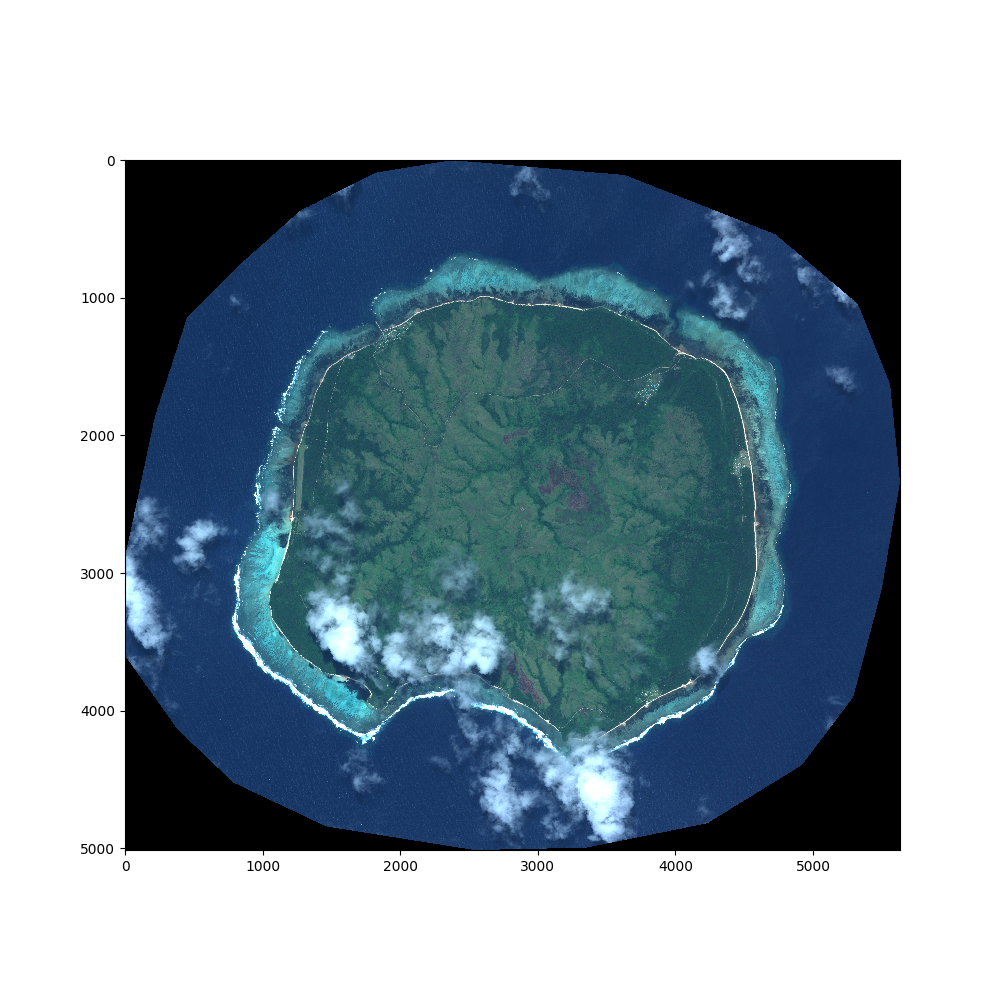

<IPython.core.display.Javascript object>


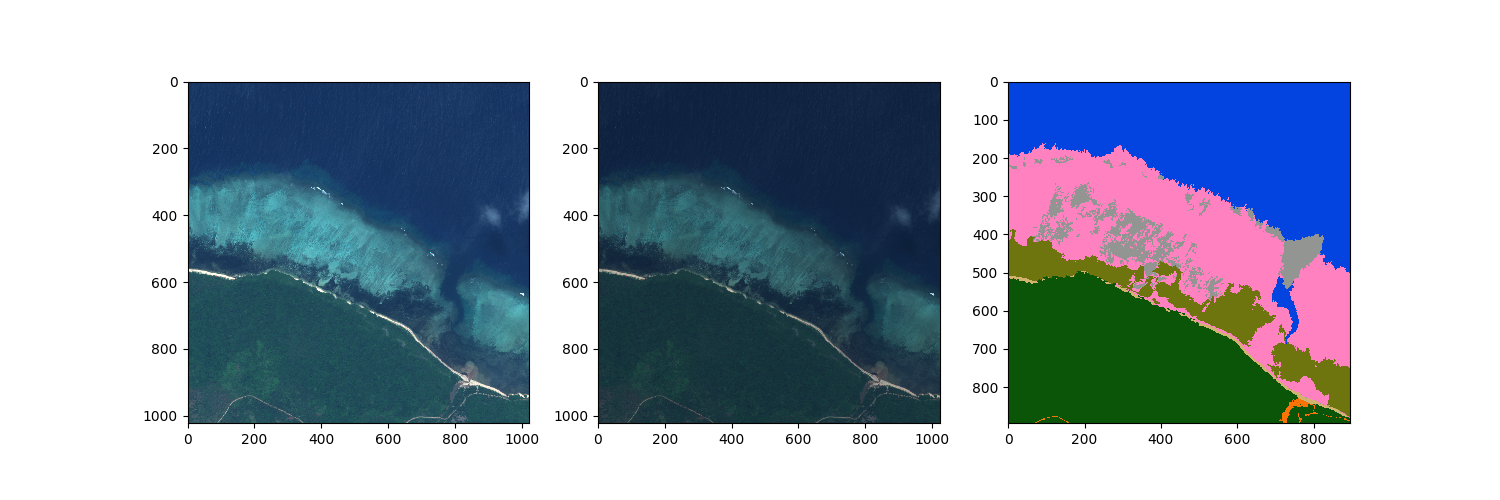

<IPython.core.display.Javascript object>


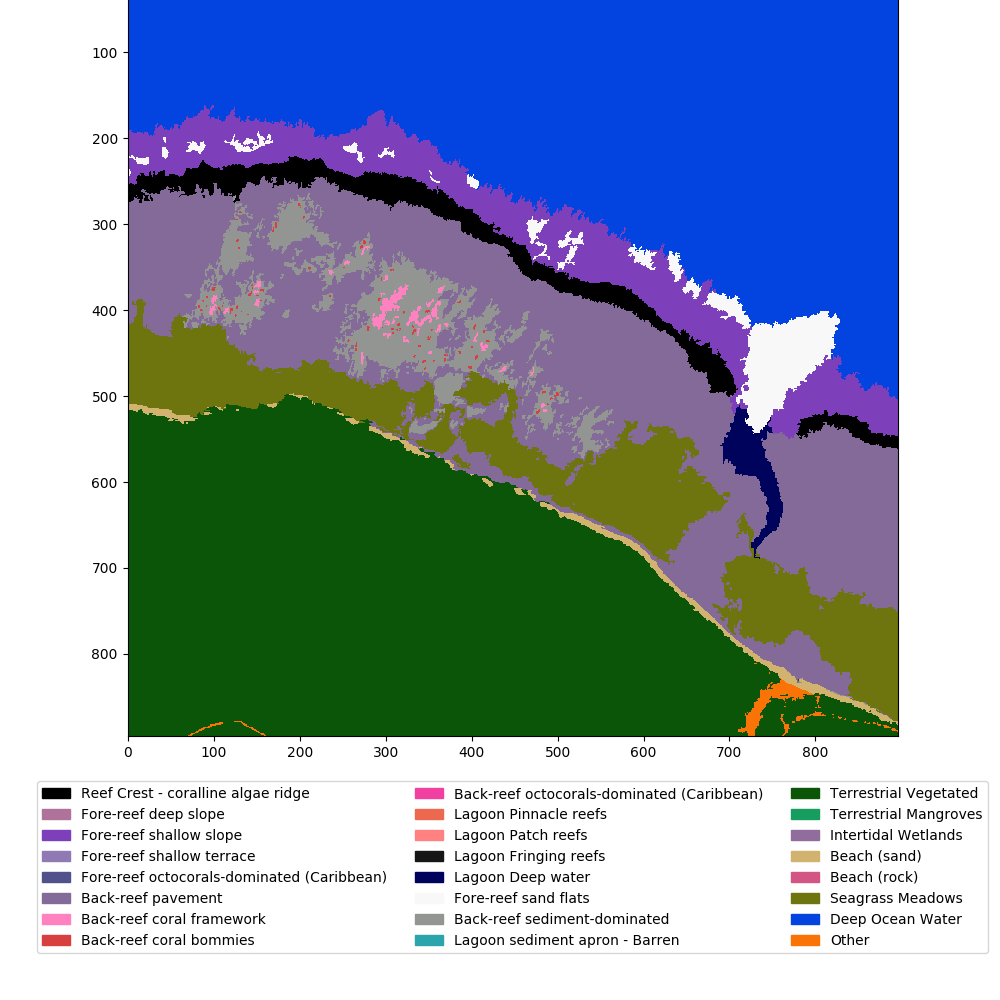

In [3]:
cmap_24classes = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:pink', '#d83f3f', '#f140a0', '#ec684e', '#ff8181',
                             '#161616', 'xkcd:dark blue', '#f8f8f8', 'xkcd:grey', '#2ca4ab',
                             'xkcd:forest', '#189d60', '#916d9e', 'xkcd:tan',
                             '#d35583', 'xkcd:olive', 'xkcd:blue', 'xkcd:orange'])
bounds_24classes = [i+0.5 for i in range(25)]
norm_24classes = colors.BoundaryNorm([b+0.5 for b in bounds_24classes], cmap_24classes.N)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

# xstart = 4100
xstart = 3200
xlen = 1024
ystart = 500
# ystart = 2900
ylen = 1024

predict_size = 128

Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
Fiji.testimage = np.delete(Fiji.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR
crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))
Testtruth = FijiTruth_Ved[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_24classes = FijiTruth_24classes[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_Major = FijiTruth_Major[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# Fiji_RGB = np.rollaxis(np.asarray([1/max_R*Fiji.image[:,:,2], 1/max_G*Fiji.image[:,:,1], 1/max_B*Fiji.image[:,:,0]]),0,3)
# print(np.unique(Testtruth))

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Fiji_RGB)

fig = plt.figure(2,figsize=(15,5))
ax = plt.subplot(131)
ax.imshow(Fiji_RGB[ystart:ystart+ylen,xstart:xstart+xlen,:])

patch_R = 255/300*Fiji.testimage[:,:,2]
patch_G = 255/300*Fiji.testimage[:,:,1]
patch_B = 255/300*Fiji.testimage[:,:,0]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
ax = plt.subplot(132)
ax.imshow(np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3))

ax = plt.subplot(133)
ax.imshow(Testtruth.astype(int), interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth_24classes.astype(int), interpolation='nearest', cmap=cmap_24classes, norm=norm_24classes)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_24classes(i)) for i in range(len(cmap_24classes.colors))],
           ['{}'.format(class_indices_rev_24classes[i+1]) for i in range(len(class_indices_rev_24classes))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

plt.show()

# print(Fiji.truthimage[250,50])

{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Line: 0 Col: 0/ 769 completed
Line: 0 Col: 128/ 769 completed
Line: 0 Col: 256/ 769 completed
Line: 0 Col: 384/ 769 completed
Line: 0 Col: 512/ 769 completed
Line: 0 Col: 640/ 769 completed
Line: 0 Col: 768/ 769 completed
Line: 128 Col: 0/ 769 completed
Line: 128 Col: 128/ 769 completed
Line: 128 Col: 256/ 769 completed
Line: 128 Col: 384/ 769 completed
Line: 128 Col: 512/ 769 completed
Line: 128 Col: 640/ 769 completed
Line: 128 Col: 768/ 769 completed
Line: 256 Col: 0/ 769 completed
Line: 256 Col: 128/ 769 completed
Line: 256 Col: 256/ 769 completed
Line: 256 Col: 384/ 769 completed
Line: 256 Col: 512/ 769 completed
Line: 256 Col: 640/ 769 completed
Line: 256 Col: 768/ 769 completed
Line: 384 Col: 0/ 769 completed
Line: 384 Col: 128/ 769 completed
Line: 384 Col: 256/ 769 completed
Line: 384 Col: 384/ 769 completed
Line: 384 Col: 

<IPython.core.display.Javascript object>


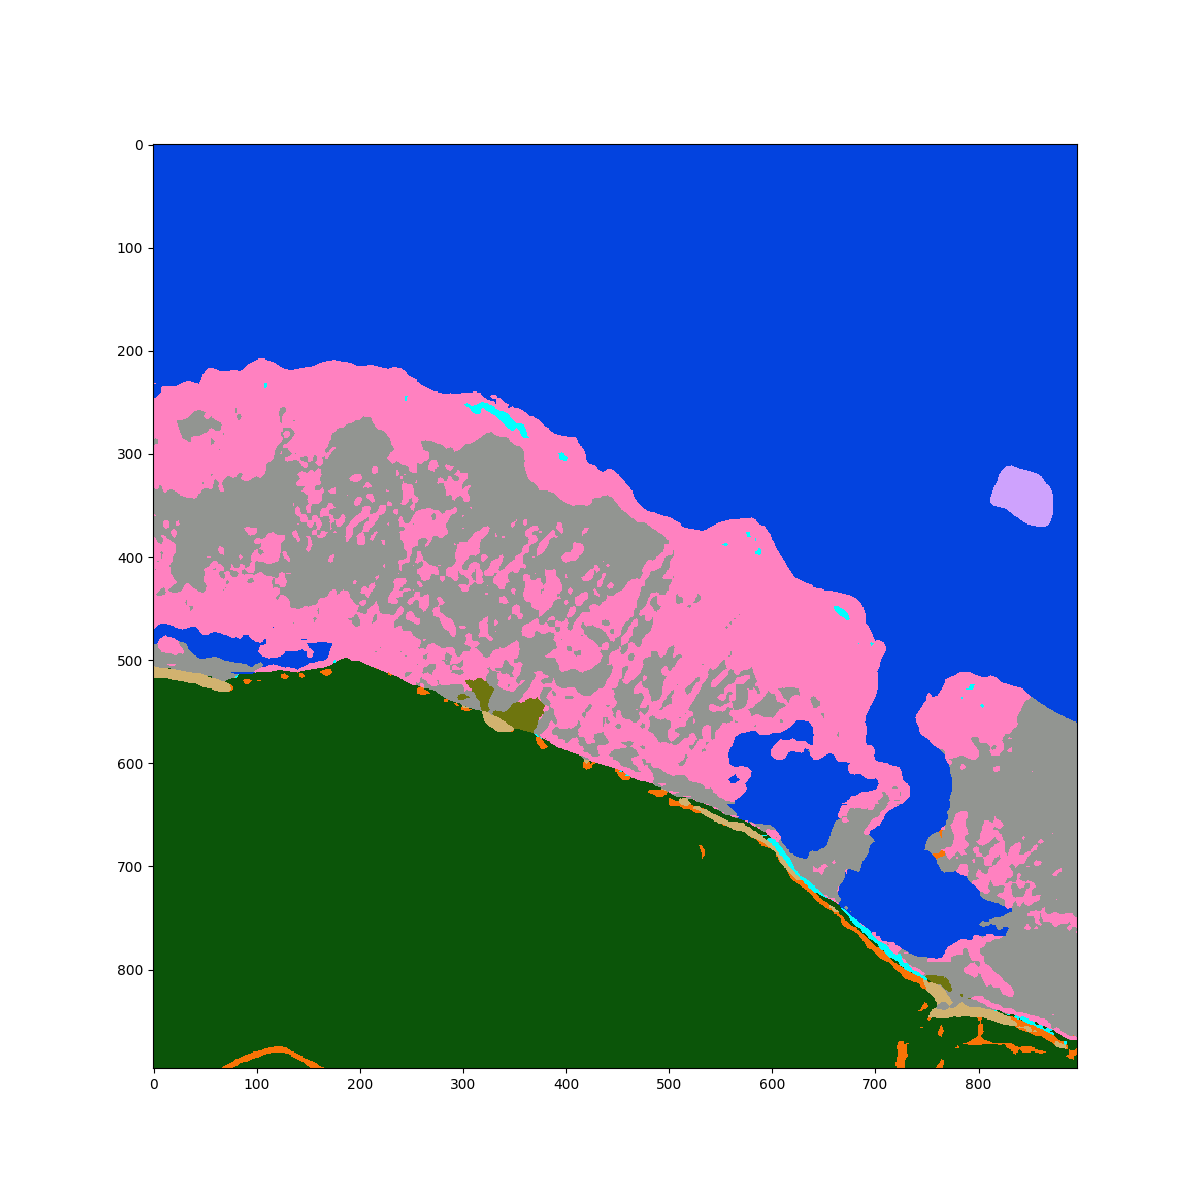

In [6]:
# PREDICTION TIME!

class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

# smallimgx = 200
# smallimgy = 675
# smalltestimg = Fiji.image[ystart+smallimgy:ystart+smallimgy+256,xstart+smallimgx:xstart+smallimgx+256,:]
# smalltestimg = np.delete(smalltestimg, [0,3,5,7], 2) # harded coded for BGR + NIR
# Fiji.testimage = smalltestimg

Fiji.set_mean_std(100,100)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (128,128), predict_size = 128, num_lines=None, lastchannelremove=False)

fig = plt.figure(10,figsize=(12,12))
# ax = plt.subplot(121)
# patch_R = 255/200*smalltestimg[:,:,2]
# patch_G = 255/200*smalltestimg[:,:,1]
# patch_B = 255/200*smalltestimg[:,:,0]
# patch_R[patch_R > 255] = 255
# patch_G[patch_G > 255] = 255
# patch_B[patch_B > 255] = 255
# smalltestimg_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# plt.imshow(smalltestimg_RGB)

ax = plt.subplot(111)
ax.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.show()


<IPython.core.display.Javascript object>


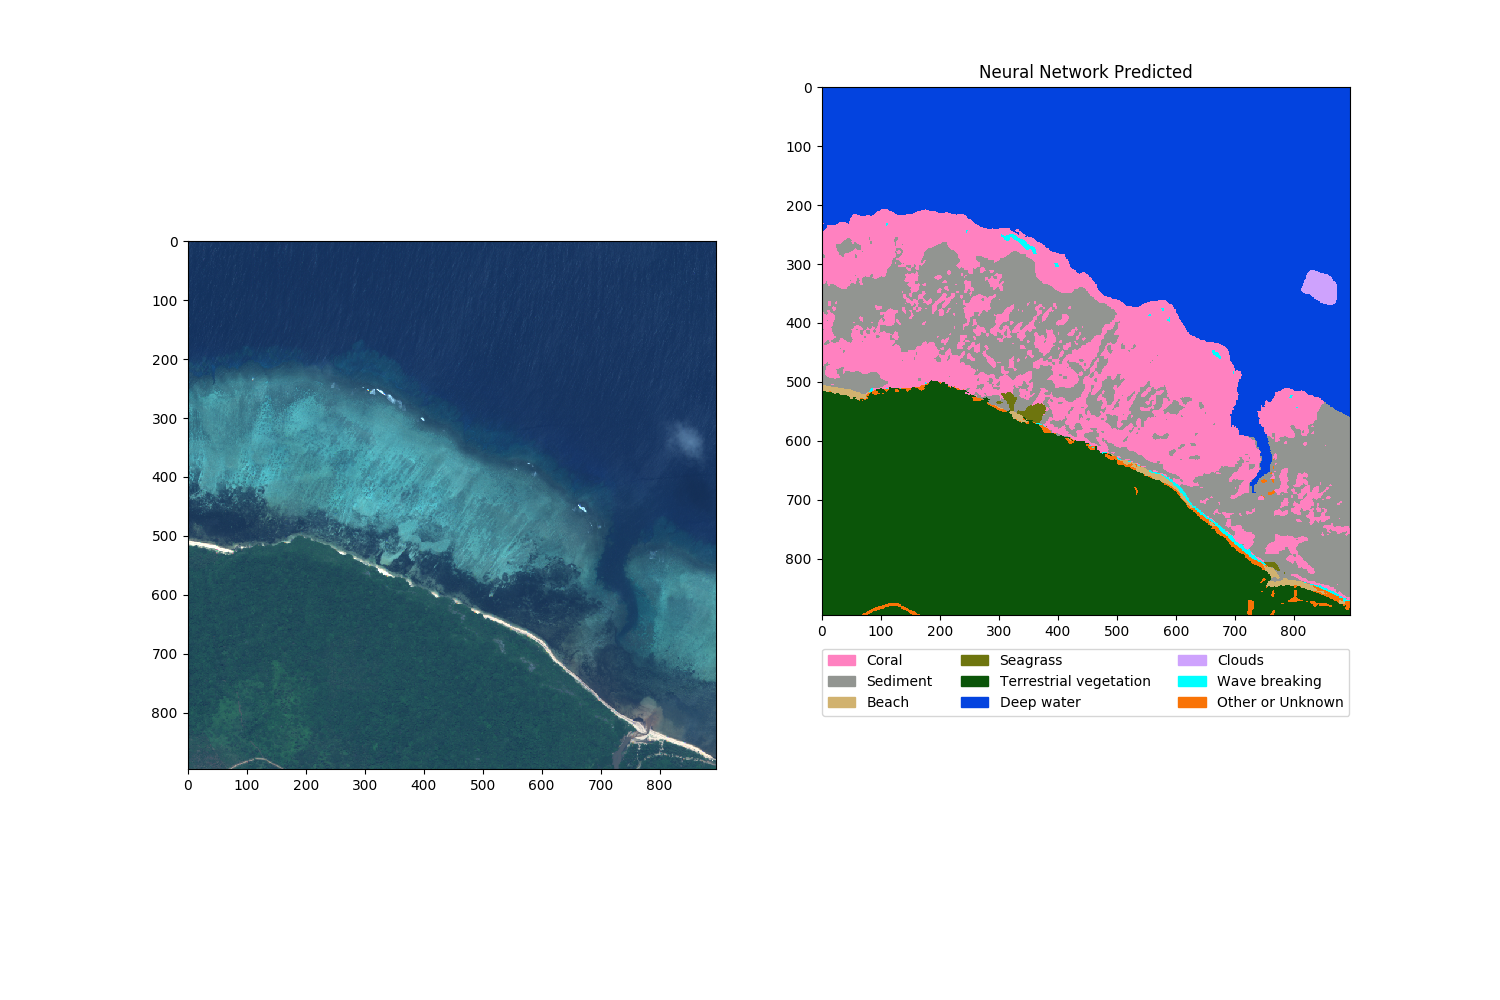

In [24]:
def MajorMask(predict_img, mask_img, prob_img, predict_labelkey, mask_labelkey):
    land = np.reshape((mask_img == mask_labelkey['Terrestrial']), (-1))
    water = np.reshape((mask_img == mask_labelkey['Deep water']), (-1))
    shallows = np.reshape((mask_img == mask_labelkey['Shallows']), (-1))
    
    original_shape = predict_img.shape
    original_prob_shape = prob_img.shape
    predict_reshape = np.reshape(np.copy(predict_img), (-1))
    prob_reshape = np.reshape(np.copy(prob_img),(-1,9))
    
    for i in range(len(predict_reshape)):
        if (land[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] != predict_labelkey['Clouds']-1) and (predict_reshape[i] != predict_labelkey['Terrestrial vegetation']-1) and (predict_reshape[i] != predict_labelkey['Other or Unknown']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1) #divide up probabilities amongst remaining
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
        elif (water[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] != predict_labelkey['Clouds']-1) and (predict_reshape[i] != predict_labelkey['Deep water']-1) and (predict_reshape[i] != predict_labelkey['Other or Unknown']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1)
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
        elif (shallows[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] == predict_labelkey['Terrestrial vegetation']-1) or (predict_reshape[i] == predict_labelkey['Deep water']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1)
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
    
    return np.reshape(predict_reshape, original_shape), np.reshape(prob_reshape, original_prob_shape)
                
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i-0.5 for i in range(len(cmap_Ved.colors)+1)] # assumes labels start at 0
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)


whole_predict_mask, whole_predict_mask_prob = MajorMask(whole_predict, Testtruth_Major, prob_predict, json_data["VedConsolidated_ClassDict"], json_data["MajorConsolidated_ClassDict"])
# prob_predict_img = np.argmax(prob_predict,axis=2)
# prob_predict_img_mask, prob_predict_img_mask_prob = MajorMask(prob_predict_img, Testtruth_Major, prob_predict, json_data["VedConsolidated_ClassDict"], json_data["MajorConsolidated_ClassDict"])

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
fig = plt.figure(4,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])

ax = plt.subplot(122)
ax.imshow(whole_predict_mask, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)], ['{}'.format(class_indices_rev[k]) for k in class_indices_rev], loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.set_axis_off()
ax.set_title('Neural Network Predicted')
plt.show()


# fig = plt.figure(3,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Testtruth-1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height])
# # ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)],
# #               ['{}'.format(class_indices_rev[k]) for k in class_indices_rev],
# #               loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax.set_title('ECognition Predicted')
# # ax.set_axis_off()
# # fig.savefig('Ecognition_Reference.png', bbox_inches='tight')
# plt.show()

In [12]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(whole_predict_mask_prob,2,0)
U = unary_from_softmax(prob_predict_switch)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(3,3), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(10,10), schan=3, img=Fiji.testimage[offstart:xlen-offstart,offstart:ylen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

KL-divergence at 0: -7154276.666593501
KL-divergence at 1: -8007242.602441557
KL-divergence at 2: -8159029.893860166
KL-divergence at 3: -8202169.226083558
KL-divergence at 4: -8223841.378023267
KL-divergence at 5: -8234845.488240956
KL-divergence at 6: -8241810.818708969
KL-divergence at 7: -8246193.531926933
KL-divergence at 8: -8249253.790294265
KL-divergence at 9: -8251462.296739633
KL-divergence at 10: -8253266.0783752045
KL-divergence at 11: -8254935.603277452
KL-divergence at 12: -8256264.826556372
KL-divergence at 13: -8257298.758989018
KL-divergence at 14: -8258153.888114139
KL-divergence at 15: -8258936.506926915
KL-divergence at 16: -8259630.486290937
KL-divergence at 17: -8260248.883959044
KL-divergence at 18: -8260828.474106718
KL-divergence at 19: -8261323.057981493


<IPython.core.display.Javascript object>


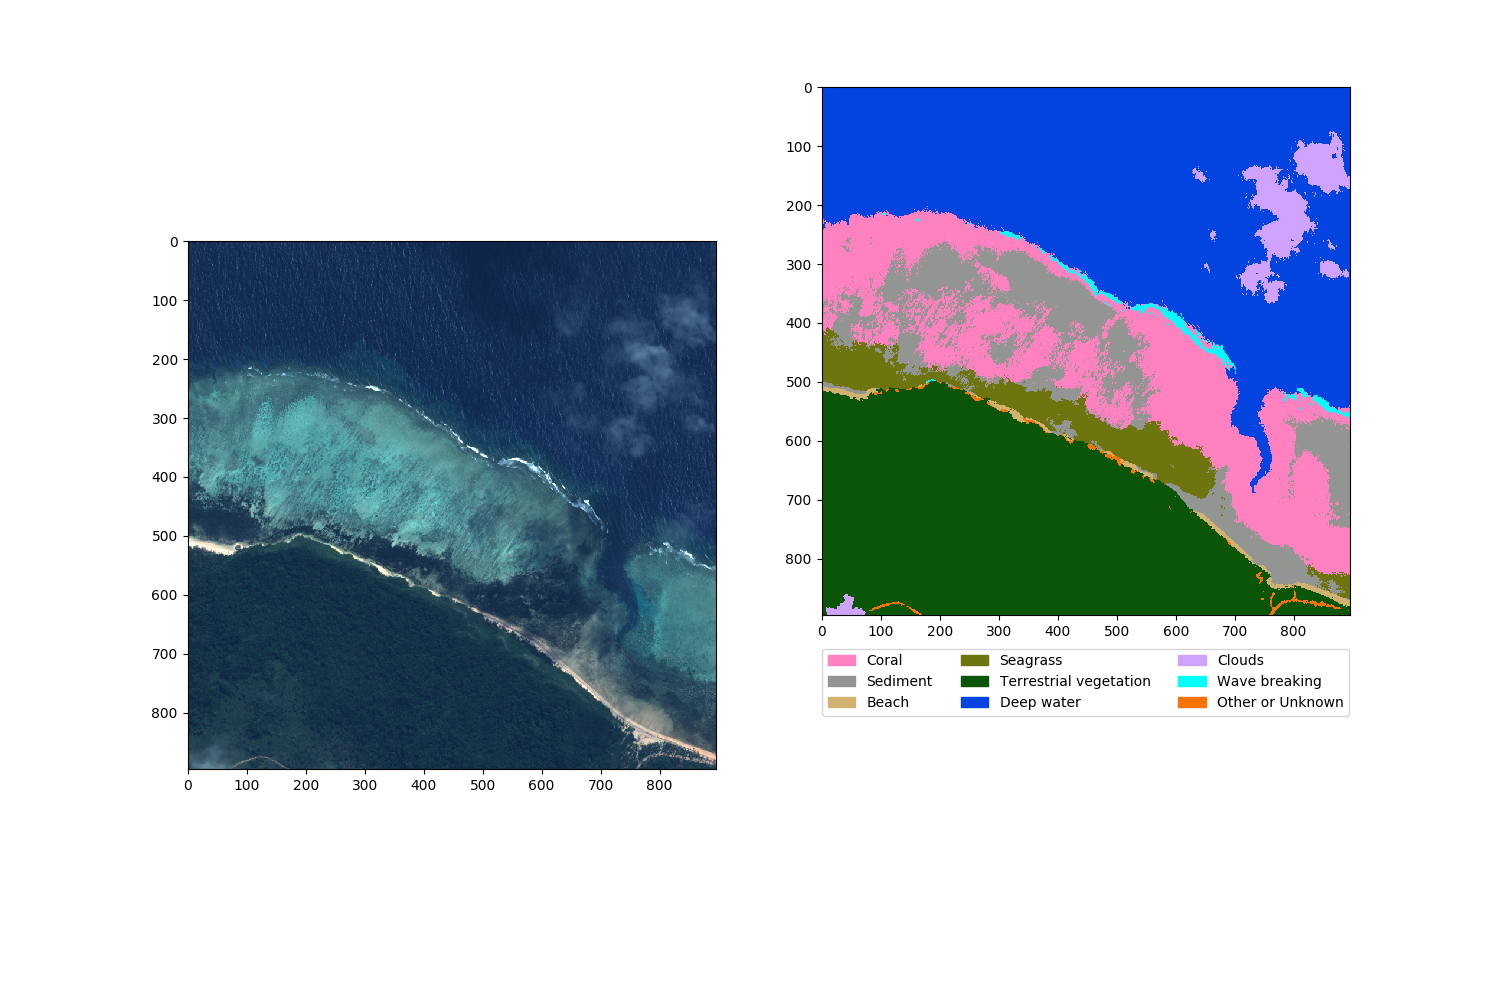

In [16]:
MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))
# accuracy = 100*np.asarray((final_predict == Testtruth_consolidated)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# print(accuracy)

fig = plt.figure(6,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])

ax = plt.subplot(122)
ax.imshow(final_predict, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax.set_axis_off()
plt.show()

In [5]:
# land = np.reshape((Testtruth == labelkey['Terrestrial vegetation']), (-1))
# print(whole_predict)
# print(labelkey)

# print(Testtruth_24classes[673,788])
yy = 436
xx = 335


print(prob_predict.shape)
print(Testtruth_Major[yy,xx])
print(whole_predict[yy,xx])
print(prob_predict[yy,xx])
print(np.argsort(prob_predict[yy,xx]))
print(np.argmax(prob_predict[yy,xx]))
print(whole_predict_mask_prob[yy,xx])
print(prob_predict_img_mask_prob[yy,xx])

print("------------")
print(prob_predict[590,399])
tempidx = np.argsort(prob_predict[590,399])
print(tempidx)

# predict_reshape[i] = sorted_idx[idx]
#                 prob_reshape[i][sorted_idx[idx]] = prob_reshape[i][sorted_idx[idx]] + prob_reshape[i][sorted_idx[idx+1]]
#                 prob_reshape[i][sorted_idx[idx+1]] = 0

# print(np.reshape(prob_predict,(-1,9)).shape)
# print(np.reshape(prob_predict,(-1,9))[0])
# print(prob_predict[495,837])
# print(np.argsort(prob_predict[495,837]))

print(Fiji.testimage[500,500])

(896, 896, 9)
1.0
4.0
[0.00700336 0.02094322 0.0050784  0.01594513 0.9182198  0.00212213
 0.02293969 0.00426425 0.003484  ]
[5 8 7 2 0 3 1 6 4]
4


NameError: name 'whole_predict_mask_prob' is not defined

In [28]:
print(whole_predict_mask[436,335])

6.0
